# **Import required Libraries!**

in the below block we're importing the libraries that we will use in the further codes in this Question!

In [1]:
import os, gzip, torch
import torch.nn as nn
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.utils as vutils

import imageio
from torch.utils.data import DataLoader

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
# from skimage import color
from skimage import img_as_ubyte

# **Find GPU Model**

in the code below we're trying to find the GPU model that Google Colab is using!

this line of code is handy and useful for us to findout we're using a proper GPU  to train our model fast as possible!

In [2]:
cur_device = torch.cuda.current_device()
device_count = torch.cuda.device_count()
print("**************************************")
print("Device Count :=> ", device_count)
print("==================================")
device_name = torch.cuda.get_device_name(0)
print("==================================")
print("Device Name :=> ", device_name)
print("**************************************")
print("######################################")
cuda_available = torch.cuda.is_available()
print("is CUDA Available :=> ", cuda_available)
print("######################################")

**************************************
Device Count :=>  1
Device Name :=>  Tesla P100-PCIE-16GB
**************************************
######################################
is CUDA Available :=>  True
######################################


# **Prepare and Import the Dataset**

in the code below we're importing and dataset CIFAR10 first!
and after that we're getting it ready for using in future! and we will use this dataset in the dataloader and getting it ready for training in the model!


we in this Question take a different approach to import the dataset we build the dataset as a class and we use it in out training Process!

in the first 3 lines of the class (2 to 5) we're specifying the transformations that we want to apply them to our dataset!

after thet ij line 7 to 9 we're using the dataloader to load our dataset with specified batch_sizes and etc...

In [3]:
def DatasetDataLoader(dataset, input_size, batch_size, split='train'):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                    ])
    if dataset == 'cifar10':
        data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)
    return data_loader

# **Setting up the Device**

in here we're setting the Hardware in which our dataset we want to be trained on! if we have GPU we will set it to ran on GPU otherwise it will ran on CPU!

if we prefer to run the model on GPU we will simply turn the ngpu to 0!

In [4]:
# Number of GPUs available. Use 0 for CPU mode.
if cuda_available is True:
    ngpu = 1
else:
    ngpu = 0
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Build a Sample from our DataSet

in the block code below we're trying to build a sample of our CIFAR10 dataset from the class of dataset that we build in the previous code block!

Files already downloaded and verified


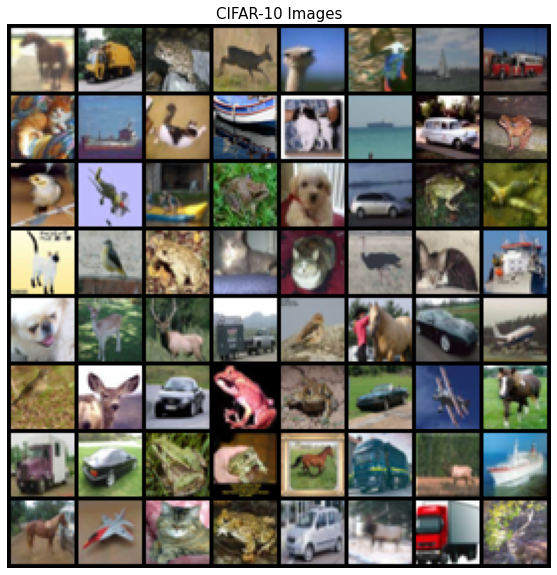

In [5]:
dataloader = DatasetDataLoader(dataset='cifar10', input_size=32, batch_size=128)
# Plot same training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("CIFAR-10 Images", fontsize=15)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# **Utility Part!**

in the three next code blocks we have some utility functions that we will use them for things like plot results and save images and etc...

# Print Network

the code block below and the function __print_network__ as it is obvious from it's name it's for printing the networks that we have builded like Generator and Discriminator!

In [6]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

# Save Image Part

in these 3 functions in code block below we're trying to save images that we have in the training loop like images the we get in each epoch from our results and etc...

we use the imageio library in python libraries to save images!

merge function is for building the block of images and after that we will save it!

In [7]:
def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))#.astype(np.uint8)
    image = img_as_ubyte(image)
    imageio.imwrite(path, image)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

# Generate GIF

in this function below named __generate_animation()__ we build a gif from the results in each epoch that we get and after that we save this generated gif!

In [8]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

# Plot Loss

this function below named __loss_plot()__ is for plotting the Losses that we get in each iteration that we have saved it in a python List and now we're going to plot these Losses!

In [9]:
def loss_plot(history, path='Train_hist.png', model_name=''):
    x = range(len(history['D_loss']))

    y1 = history['D_loss']
    y2 = history['G_loss']
    plt.figure(figsize=(25, 7))
    plt.title("Generator and Discriminator Loss During Training", fontsize=17)
    plt.plot(x, y1, label='Discriminator Loss')
    plt.plot(x, y2, label='Generator Loss')

    plt.xlabel('iterations')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

# Initialize Weights

this function below named __initialize_weights__ is for initializing weights to our generator and discriminator and we're using it while building them!

In [10]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)

# **Generator Part of CGAN**

in this block of code below we're trying to Design a Generator Network for our CGAN architecture!


in this Generator we're giving a noise as input to the Generator and as output we're taking back generated images!


in this Generator we have some differences compare to the Generator that we had in Question #2 and the most important difference is that as you can see in line 10 and 7 we're specifying the class of the input noise and after that we build our image and generate it according the class and label of the input that we want and that is how CGAN should exactly work according to the CGAN paper!

also as you can see in lines 26 and 27 in code below we're sending the label of the input beside the label it self in order to build Generator for the CGAN!

---------------
in the first 5 lines in the class we're setting the parameters of the class!

after that we have a Sequential part which means that the layers inside it will place after each other and in order that we specified! in this part we specify the label of our input after that we have a deconv part which is cosist of 2 Deconvolution layers!

in line 24 we are doing a initialization on the weights of the Model!

In [11]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=self.output_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

# **Discriminator part of CGAN**

in this block code below we're building the Discriminator for our CGAN!

as you can see in the __init__ part of the below code in line 2 & 7 & 10 we're giving the label and class to the network that is how we give condition to the network by specifiying the class of the Images that we give as input!

also in the forward part you could see in line 25 and 26 that we give the label of the input to the network!

----------------------------------

in the forst 5 lines of the class (line 3 to 7) you could see that we're setting the hyperparameters of the network!

after that in line 9 to 15 we're setting our convolution layers that get the images and use conv filter on them with Batch Normalization and in here we're using Leaky ReLU as activation function!

and from line 16 to 22 we're using 2 dense layers.



In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim + self.class_num, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# **CGAN Model**

in the code block below we're designing a class named CGAN that in this class __init__ part we're specifiying the Hyperparameters of the Model and network and also load the dataset and build the Generator and Discriminator.
after that in __init__ part if we have gpu available then we send our data and calculations to gpu for faster and beter performance!

after these in __init__ part we're building fixed noise with condition this means that we are building seperte noise for each class and label we have in the dataset! in our case we have 10 classes!

line 27 to 32: in these lines we set the Loss function for our calculations and it __"is BCELoss()"__ loss function that i have completely explain it in the question #2 notebook and i won't mention it here again!


----------------------
After __init__ we have __train__ part! in train the process is mostly the same as question #2 we slightly changed the part that we give input to the generator and discriminator because of the conditions that we have to apply!

in the line 66 to 74 we define some variables to keep track of the running time of the training and etc.

after that in line 76 we build and initialize a vector for out network output!

in line 77 & 78 we turn the builded vector into gpu if it is available!

in line 83 till end of the train function we have the training process!

first in line 89 we take a batch of our data and start to process on it!

at start we have 88 and some lines after functions like time.time() rto keep track of the time that it takes to out network be trained!

lines 93 till 95 are the most change in here from question 2 in this part we generate a noise and vector according to the class of data that we have and send it to the process!

line 100: in this line we zero the gradient of the Discriminator.

line 102: in this line we give the inputs and labels of our data to the discriminator.

line 103: in this line we calculate the loss of the Discriminator for real data!

line 105 we give the generated noise and the label of our data to the generator to generate for us fake images.

in line 106: we give the generated images to the discriminator and take the output of it. and after that in line 107 we calculate the loss of the outputs that we get!

in line 109: we sum the loss results from both process on the discriminator.

line 110: in this line we add the calculated loss to a list to keep track of it for further plotting parts!!!

112: in this line we back track and apply the gradients on the discriminator!

line 116: in this line we set the gradient of the generator to zero!

line 118 till 120: in these lines we give our generated noise and vector to the generator and take the results and give these results with labels to the dicriminator and after that we calculate the loss for this part!

lines after that have nothing important to discuss!!

---------------------------

next in line 150 we define a new function named __visualize_results__.

in this function we're getting the results and the generated images from each epoch and we try to save them!

--------------------------

Line 179 till 190: in these lines we have a __save()__ function that it is for saving the history of the training process and results for our network!

--------------

line 191 till end: in these lines we have a __load()__ function that we use it if we want to load the saved results from save function!


In [13]:
class CGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, log_dir, gpu_mode, gan_type, input_size, beta1=0.5, beta2=0.999, lrG=0.0002, lrD=0.0002):
        # parameters
        self.epoch = epoch
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.dataset = dataset
        self.log_dir = log_dir
        self.gpu_mode = gpu_mode
        self.model_name = gan_type
        self.input_size = input_size
        self.z_dim = 62
        self.class_num = 10
        self.sample_num = self.class_num ** 2

        # load dataset
        self.data_loader = DatasetDataLoader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.Generator = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size, class_num=self.class_num)
        self.Discriminator = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size, class_num=self.class_num)
        self.Generator_optimizer = optim.Adam(self.Generator.parameters(), lr=lrG, betas=(beta1, beta2))
        self.Discriminator_optimizer = optim.Adam(self.Discriminator.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.gpu_mode:
            self.Generator.cuda()
            self.Discriminator.cuda()
            self.criterion = nn.BCELoss().cuda()
        else:
            self.criterion = nn.BCELoss()
        print("===============================================================")
        print('------------------- Networks architecture ---------------------')
        print("###############################################################")
        print("*********************** Generator Model ***********************")
        print("###############################################################")
        print_network(self.Generator)
        print("###############################################################")
        print("******************** Discriminator Model **********************")
        print("###############################################################")
        print_network(self.Discriminator)
        print('---------------------------------------------------------------')
        print("===============================================================")

        # fixed noise & condition
        self.sample_z_ = torch.zeros((self.sample_num, self.z_dim)) #, device=device)
        for i in range(self.class_num):
            self.sample_z_[i*self.class_num] = torch.rand(1, self.z_dim)
            for j in range(1, self.class_num):
                self.sample_z_[i*self.class_num + j] = self.sample_z_[i*self.class_num]

        temp = torch.zeros((self.class_num, 1))
        for i in range(self.class_num):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.class_num):
            temp_y[i*self.class_num: (i+1)*self.class_num] = temp

        self.sample_y_ = torch.zeros((self.sample_num, self.class_num)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        if self.gpu_mode:
            self.sample_z_, self.sample_y_ = self.sample_z_.cuda(), self.sample_y_.cuda()

    def train(self):
        # Lists to keep track of progress
        img_list = []
        G_losses = []
        D_losses = []
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.Discriminator.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.Generator.train()
            print("|==================================================================================================|")
            print("|******************************************* Epoch:=> {0} *******************************************|".format(epoch+1))
            print("|==================================================================================================|")
            epoch_start_time = time.time()
            for iter, (x_, y_) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim)) #, device=device)
                y_vec_ = torch.zeros((self.batch_size, self.class_num)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                y_fill_ = y_vec_.unsqueeze(2).unsqueeze(3).expand(self.batch_size, self.class_num, self.input_size, self.input_size)
                if self.gpu_mode:
                    x_, z_, y_vec_, y_fill_ = x_.cuda(), z_.cuda(), y_vec_.cuda(), y_fill_.cuda()

                # update D network
                self.Discriminator_optimizer.zero_grad()

                D_real = self.Discriminator(x_, y_fill_)
                D_real_loss = self.criterion(D_real, self.y_real_)

                G_ = self.Generator(z_, y_vec_)
                D_fake = self.Discriminator(G_, y_fill_)
                D_fake_loss = self.criterion(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.Discriminator_optimizer.step()

                # update Generator network
                self.Generator_optimizer.zero_grad()

                G_ = self.Generator(z_, y_vec_)
                D_fake = self.Discriminator(G_, y_fill_)
                G_loss = self.criterion(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.Generator_optimizer.step()

                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())


                if ((iter + 1) % 100) == 0:
                    print("|  Epoch: [%2d/%2d] [%4d /%4d]:=> Dicriminator Loss: %.8f  /&/  Generator Loss: %.8f  |" %
                          ((epoch + 1), self.epoch, (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)

        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name, self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        return G_losses, D_losses

    def visualize_results(self, epoch, fix=True):
        self.Generator.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        image_frame_dim = int(np.floor(np.sqrt(self.sample_num)))

        if fix:
            """ fixed noise """
            samples = self.Generator(self.sample_z_, self.sample_y_)
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_, sample_y_ = sample_z_.cuda(), sample_y_.cuda()

            samples = self.Generator(sample_z_, sample_y_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.Generator.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.Discriminator.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.Generator.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.Discriminator.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

# **Main Execution Part**

in this block of code below we're trying to execute the CGAN Network that we have build in the code block above!
we specify the hyperparameters and then build an instance from the model and send the hyperparameters to the model!
then we start the training Process and visualize the results after that!

In [14]:
"""main"""
def main():
    # declare instance for GAN
    # Number of training epochs
    num_epochs = 333

    # Learning rate for optimizers
    # Generator LR
    lr_G = 0.0002
    # Discriminator LR
    lr_D = 0.002

    gan = CGAN(epoch=num_epochs, batch_size=128, save_dir='models', result_dir='results', dataset='cifar10', log_dir='logs', gpu_mode=True, gan_type='CGAN', input_size=32, beta1=0.5, beta2=0.999, lrG=lr_G, lrD=lr_D)


    # launch the graph in a session
    G_losses, D_losses = gan.train()
    print(" [*] Training finished!")

    # visualize learned generator
    gan.visualize_results(num_epochs)
    print(" [*] Testing finished!")
    return G_losses, D_losses

if __name__ == '__main__':
    G_losses, D_losses = main()

Files already downloaded and verified
------------------- Networks architecture ---------------------
###############################################################
*********************** Generator Model ***********************
###############################################################
Generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=8192, bias=True)
    (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), pa

#  Plot Loss

in the block code below we're going to plot the Losses that we have get in training iterations!

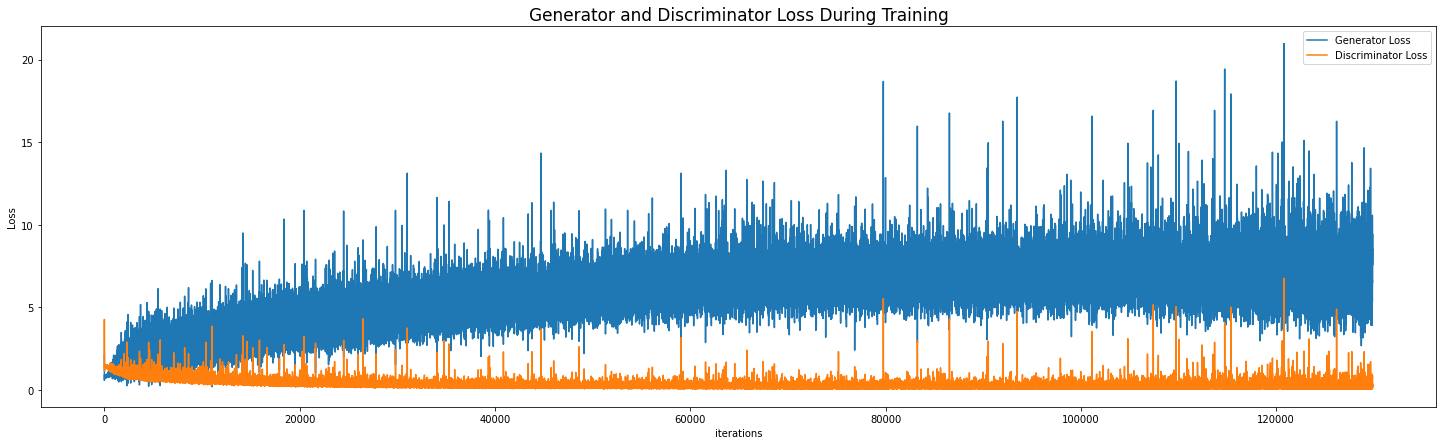

In [15]:
plt.figure(figsize=(25, 7))
plt.title("Generator and Discriminator Loss During Training", fontsize=17)
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Zip the Result

now i'm zipping the results that we have saved in google colab in order to use them.

In [16]:
!zip -r /content/results/cifar10/CGAN.zip /content/results/

  adding: content/results/ (stored 0%)
  adding: content/results/cifar10/ (stored 0%)
  adding: content/results/cifar10/CGAN/ (stored 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch155.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch293.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch180.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch159.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch214.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch127.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch171.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch255.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch222.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch333.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch109.png (deflated 0%)
  adding: content/results/cifar10/CGAN/CGAN_epoch197.png (deflated 0%)
  adding: 

# Download Zipped file

in here i'm downloading the file that i have zipped in previous block!

In [17]:
from google.colab import files
files.download("/content/results/cifar10/CGAN.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>